<a href="https://colab.research.google.com/github/deschena/networks_ml_epfl/blob/main/assignment4/Assignment4NML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4: Graph Neural Networks

Contact: [Abdellah RAHMANI](mailto:abdellah.rahmani@epfl.ch) [Jinhan LIU](mailto:jinhan.liu@epfl.ch)

## Rules

> ⚠️ **Read carefully before starting**

**Deadline:** May 16th

**Grading:**
* The integrality of Assignment 4 will be scaled to 100% and will amount to 25% of the overall assignments score.
* The total number of points is **40**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Anything outside shall not be touched, except if otherwise stated.

Theoretical questions shall be answered in the following markdown cell. The first line will be 
> **Your answer here:**

**Submission:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored

* You cannot import any other library than we imported.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations

# Objective

The purpose of this assignment is to first understand and explore the building blocks of Graph Neural Networks (GNN), and then try to implement more up-to-date GNN architectures or build up new ones using your own ideas. 

Through these two sections, we hope that you could obtain solid understanding of GNN components and architectures, and gain more experience in solving practical tasks using basic models and then try to improve upon it.

# First part: Understanding Pooling and Graph Convolutional Layers (20 pts)
In the first part, you will try to go through our implementation of a Graph Convolution Network, and discover both the key components and the entire structure of a typical GNN. 

In this section, implementation is not required. Rather, you are requested to execute the various code sections, analyze their outcomes, and provide an explanation of the results. The objective is to understand pooling in graphs and also graph convolutional with spectral filtering. 

# Graph ConvNets in PyTorch

PyTorch implementation of the NeurIPS'16 paper:
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering
M Defferrard, X Bresson, P Vandergheynst
Advances in Neural Information Processing Systems, 3844-3852, 2016
[ArXiv preprint](https://arxiv.org/abs/1606.09375)

## Code:

The code provides a simple example of graph ConvNets for the MNIST classification task.
The graph is a 8-nearest neighbor graph of a 2D grid.
The signals on graph are the MNIST images vectorized as $28^2 \times 1$ vectors.

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import collections
import time
import numpy as np
import scipy
from functools import partial
import os

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

cuda available


# Connect to your drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
ROOT_PATH = "/content/drive/MyDrive/EPFL/Network ML/assignment4"
print(os.listdir(ROOT_PATH))

['grid_graph.py', 'coarsening.py']


In [ ]:
import sys
sys.path.append(ROOT_PATH)

## Loading the data

This code is only to load the Mnist data set, you just need to run it

In [ ]:
def check_mnist_dataset_exists(path_data='./'):
    flag_train_data = os.path.isfile(path_data + 'mnist/train_data.pt') 
    flag_train_label = os.path.isfile(path_data + 'mnist/train_label.pt') 
    flag_test_data = os.path.isfile(path_data + 'mnist/test_data.pt') 
    flag_test_label = os.path.isfile(path_data + 'mnist/test_label.pt') 
    if flag_train_data==False or flag_train_label==False or flag_test_data==False or flag_test_label==False:
        print('MNIST dataset preprocessing...')
        import torchvision
        import torchvision.transforms as transforms
        trainset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=True,
                                                download=True, transform=transforms.ToTensor())
        testset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=False,
                                               download=True, transform=transforms.ToTensor())
        train_data=torch.Tensor(60000,28,28)
        train_label=torch.LongTensor(60000)
        for idx , example in enumerate(trainset):
            train_data[idx]=example[0].squeeze()
            train_label[idx]=example[1]
        torch.save(train_data,path_data + 'mnist/train_data.pt')
        torch.save(train_label,path_data + 'mnist/train_label.pt')
        test_data=torch.Tensor(10000,28,28)
        test_label=torch.LongTensor(10000)
        for idx , example in enumerate(testset):
            test_data[idx]=example[0].squeeze()
            test_label[idx]=example[1]
        torch.save(test_data,path_data + 'mnist/test_data.pt')
        torch.save(test_label,path_data + 'mnist/test_label.pt')
    return path_data


_ = check_mnist_dataset_exists()

In [ ]:
#if you want to play with a small dataset (for cpu), uncomment.
nb_selected_train_data = 60000
nb_selected_test_data = 10000

train_data=torch.load('mnist/train_data.pt').reshape(60000,784).numpy()
train_data = train_data[:nb_selected_train_data,:]
print(train_data.shape)

train_labels=torch.load('mnist/train_label.pt').numpy()
train_labels = train_labels[:nb_selected_train_data]
print(train_labels.shape)

test_data=torch.load('mnist/test_data.pt').reshape(10000,784).numpy()
test_data = test_data[:nb_selected_test_data,:]
print(test_data.shape)

test_labels=torch.load('mnist/test_label.pt').numpy()
test_labels = test_labels[:nb_selected_test_data]
print(test_labels.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Here we construct the graph using the 8-nearest neighbors of a 2D grid using Euclidean distance metrics.

In [ ]:
from grid_graph import grid_graph
from coarsening import coarsen, HEM, compute_perm, perm_adjacency
from coarsening import perm_data

# Construct graph
t_start = time.time()
grid_side = 28
number_edges = 8
metric = 'euclidean'


######## YOUR GRAPH ADJACENCY MATRIX HERE ########
A = grid_graph(grid_side,number_edges,metric) # create graph of Euclidean grid
######## YOUR GRAPH ADJACENCY MATRIX HERE ########

nb edges:  6396


In the following two cells we build up functions for calculating the graph Laplacian and retrieving the largest eigenvalue of it with scaling .

In [ ]:
def laplacian(W, normalized=True):
    """Return graph Laplacian"""
    I = scipy.sparse.identity(W.shape[0], dtype=W.dtype)

    #W += I
    # Degree matrix.
    d = W.sum(axis=0)
    # Laplacian matrix.
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d_inv = 1/d
        Dinv = scipy.sparse.csr_matrix.sqrt(scipy.sparse.diags(d_inv.A.squeeze(), 0))
        L =  - Dinv.dot(W.dot(Dinv))# i modified this normalization in order to use it in question 5 Lsym  = Lsym-I

        pass

    assert np.abs(L - L.T).mean() < 1e-8
    assert type(L) is scipy.sparse.csr.csr_matrix
    return L

In [ ]:
def rescale_L(L, lmax=2):
    """Rescale Laplacian eigenvalues to [-1,1]"""
    M, M = L.shape
    I = scipy.sparse.identity(M, format='csr', dtype=L.dtype)
    L /= lmax * 2
    L -= I
    return L 

def lmax_L(L):
    """Compute largest Laplacian eigenvalue"""
    return scipy.sparse.linalg.eigsh(L, k=1, which='LM', return_eigenvectors=False)[0]

In the following cells, we can try to implement the graph coarsening with a specific coarsening level and retrieve the corresponding largest eigenvalues of Laplacians of the coarsened graphs. 

In [ ]:
# Compute coarsened graphs
coarsening_levels = 4

L, perm = coarsen(A, coarsening_levels, partial(laplacian, normalized=True))

Heavy Edge Matching coarsening with Xavier version
Layer 0: M_0 = |V| = 960 nodes (176 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 480 nodes (77 added), |E| = 1618 edges
Layer 2: M_2 = |V| = 240 nodes (29 added), |E| = 781 edges
Layer 3: M_3 = |V| = 120 nodes (7 added), |E| = 388 edges
Layer 4: M_4 = |V| = 60 nodes (0 added), |E| = 194 edges


<ipython-input-9-d29d56694506>:13: RuntimeWarning: divide by zero encountered in true_divide
  d_inv = 1/d
<ipython-input-9-d29d56694506>:20: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  assert type(L) is scipy.sparse.csr.csr_matrix


In [ ]:
# Compute coarsened graphs
coarsening_levels = 4

L, perm = coarsen(A, coarsening_levels, partial(laplacian, normalized=False))

# Compute max eigenvalue of graph Laplacians
lmax = []
for i in range(coarsening_levels):
    lmax.append(lmax_L(L[i]))
print('lmax: ' + str([lmax[i] for i in range(coarsening_levels)]))

# Reindex nodes to satisfy a binary tree structure
train_data = perm_data(train_data, perm)
test_data = perm_data(test_data, perm)

print('Execution time: {:.2f}s'.format(time.time() - t_start))
del perm

Heavy Edge Matching coarsening with Xavier version


<ipython-input-9-d29d56694506>:20: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  assert type(L) is scipy.sparse.csr.csr_matrix


Layer 0: M_0 = |V| = 960 nodes (176 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 480 nodes (77 added), |E| = 1618 edges
Layer 2: M_2 = |V| = 240 nodes (29 added), |E| = 781 edges
Layer 3: M_3 = |V| = 120 nodes (7 added), |E| = 388 edges
Layer 4: M_4 = |V| = 60 nodes (0 added), |E| = 194 edges
lmax: [5.87704, 11.296647, 19.596706, 30.225954]
Execution time: 1.72s


Here, we implemented the pooling layers and computed the list `L` containing the Laplacians of the graphs for each layer.

## <font color='red'>Question 1: what is the size of the various poolings? (2pts) </font> 

> **Your answer here:** The size of the various pooling is 944, 472, 236, 118, 59. These are obtained after each round of the Heavy Edge Matching algorithm.

# Graph ConvNet LeNet5

With the components including graph coarsening and graph Laplacian computation, now we can build a entire GNN architecture for the image classification task, such as the classic Graph ConvNet LeNet5, which contains 2 graph convolutional layers, 2 pooling layers with size 4 and two fully-connected layers as shown below:

1. Convolutional layer (Dim=32)
2. Max pooling layer (Dim=4)
3. Convolutional layer (Dim=64)
4. Max pooling layer (Dim=4)
5. Fully-connected layer (Dim=512)
6. Fully-connected layer (Dim=10)

## <font color='red'>Question 2: which graphs will you take in the list `L` for the graph convolutional layers? (2pts)</font> 



> **Your answer here:** The graphs 0 and 2, i.e. the ones with 944 and 236 nodes.

Let's define a torch class of GNN module and initialize our Graph ConvNet LeNet5 using its network parameter settings.

In [ ]:
class Graph_ConvNet_LeNet5(nn.Module):
    
    def __init__(self, net_parameters, rescale = True):
        
        print('Graph ConvNet: LeNet5')
        
        super(Graph_ConvNet_LeNet5, self).__init__()
        
        # parameters
        self.rescale = rescale
        D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F = net_parameters
        FC1Fin = CL2_F*(D//16)
        
        # graph CL1
        self.cl1 = nn.Linear(CL1_K, CL1_F) 
        self.init_layers(self.cl1, CL1_K, CL1_F)
        self.CL1_K = CL1_K; self.CL1_F = CL1_F; 
        
        # graph CL2
        self.cl2 = nn.Linear(CL2_K*CL1_F, CL2_F) 
        self.init_layers(self.cl2, CL2_K*CL1_F, CL2_F)
        self.CL2_K = CL2_K; self.CL2_F = CL2_F; 

        # FC1
        self.fc1 = nn.Linear(FC1Fin, FC1_F) 
        self.init_layers(self.fc1, FC1Fin, FC1_F)
        self.FC1Fin = FC1Fin
        
        # FC2
        self.fc2 = nn.Linear(FC1_F, FC2_F)
        self.init_layers(self.fc2, FC1_F, FC2_F)

        # nb of parameters
        nb_param = CL1_K* CL1_F + CL1_F          # CL1
        nb_param += CL2_K* CL1_F* CL2_F + CL2_F  # CL2
        nb_param += FC1Fin* FC1_F + FC1_F        # FC1
        nb_param += FC1_F* FC2_F + FC2_F         # FC2
        print('nb of parameters=',nb_param,'\n')
        
        
    def init_layers(self, W, Fin, Fout):

        scale = np.sqrt( 2.0/ (Fin+Fout) )
        W.weight.data.uniform_(-scale, scale)
        W.bias.data.fill_(0.0)

        return W
        
        
    def graph_conv_cheby(self, x, cl, L, lmax, Fout, K):
        # parameters
        # B = batch size
        # V = nb vertices
        # Fin = nb input features
        # Fout = nb output features
        # K = Chebyshev order & support size
        B, V, Fin = x.size(); B, V, Fin = int(B), int(V), int(Fin) 

        # rescale Laplacian
        lmax = lmax_L(L)
        if self.rescale:
          
          L = rescale_L(L, lmax) 
        
        # convert scipy sparse matric L to pytorch
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col)).T 
        indices = indices.astype(np.int64)
        indices = torch.from_numpy(indices)
        indices = indices.type(torch.LongTensor)
        L_data = L.data.astype(np.float32)
        L_data = torch.from_numpy(L_data) 
        L_data = L_data.type(torch.FloatTensor)
        L = torch.sparse.FloatTensor(indices, L_data, torch.Size(L.shape))
        L.requires_grad_(False)
        if torch.cuda.is_available():
            L = L.cuda()
        # transform to Chebyshev basis
        x0 = x.permute(1,2,0).contiguous()  # V x Fin x B
        x0 = x0.view([V, Fin*B])            # V x Fin*B
        x = x0.unsqueeze(0)                 # 1 x V x Fin*B
        
        def concat(x, x_):
            x_ = x_.unsqueeze(0)            # 1 x V x Fin*B
            return torch.cat((x, x_), 0)    # K x V x Fin*B  
             
        if K > 1: 
            x1 = torch.mm(L,x0)              # V x Fin*B
            x = torch.cat((x, x1.unsqueeze(0)),0)  # 2 x V x Fin*B
        for k in range(2, K):
            x2 = 2 * torch.mm(L,x1) - x0  
            x = torch.cat((x, x2.unsqueeze(0)),0)  # M x Fin*B
            x0, x1 = x1, x2  
        
        x = x.view([K, V, Fin, B])           # K x V x Fin x B     
        x = x.permute(3,1,2,0).contiguous()  # B x V x Fin x K       
        x = x.view([B*V, Fin*K])             # B*V x Fin*K
        
        # Compose linearly Fin features to get Fout features
        x = cl(x)                            # B*V x Fout  
        x = x.view([B, V, Fout])             # B x V x Fout
        return x
        
        
    # Max pooling of size p. Must be a power of 2.
    def graph_max_pool(self, x, p): 
        if p > 1: 
            x = x.permute(0,2,1).contiguous()  # x = B x F x V
            x = nn.MaxPool1d(p)(x)             # B x F x V/p          
            x = x.permute(0,2,1).contiguous()  # x = B x V/p x F
            return x  
        else:
            return x   
        
        
    def forward(self, x, d, L, lmax):
        # graph CL1
        x = x.unsqueeze(2) # B x V x Fin=1  
        x = self.graph_conv_cheby(x, self.cl1, L[0], lmax[0], self.CL1_F, self.CL1_K)
        x = F.relu(x)
        x = self.graph_max_pool(x, 4)
        # graph CL2
        x = self.graph_conv_cheby(x, self.cl2, L[2], lmax[2], self.CL2_F, self.CL2_K)
        x = F.relu(x)
        x = self.graph_max_pool(x, 4)
        # FC1
        x = x.view(-1, self.FC1Fin)
        x = self.fc1(x)
        x = F.relu(x)
        x  = nn.Dropout(d)(x)
        # FC2
        x = self.fc2(x)
        return x
        
        
    def loss(self, y, y_target, l2_regularization):
    
        loss = nn.CrossEntropyLoss()(y,y_target)

        l2_loss = 0.0
        for param in self.parameters():
            data = param* param
            l2_loss += data.sum()
           
        loss += 0.5* l2_regularization* l2_loss
            
        return loss
    
    
    def update(self, lr):
                
        update = torch.optim.SGD( self.parameters(), lr=lr, momentum=0.9 )
        
        return update
        
        
    def update_learning_rate(self, optimizer, lr):
   
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

    
    def evaluation(self, y_predicted, test_l):
    
        _, class_predicted = torch.max(y_predicted.data, 1)
        return 100.0* (class_predicted == test_l).sum()/ y_predicted.size(0)

In [ ]:
# Delete existing network if exists
try:
    del net
    print('Delete existing network\n')
except NameError:
    print('No existing network to delete\n')

# network parameters
D = train_data.shape[1]
CL1_F = 32
CL1_K = 25
CL2_F = 64
CL2_K = 25
FC1_F = 512
FC2_F = 10
net_parameters = [D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F]
dropout_value = 0.5

# instantiate the object net of the class 
net = Graph_ConvNet_LeNet5(net_parameters)
if torch.cuda.is_available():
    net.cuda()
print(net)

No existing network to delete

Graph ConvNet: LeNet5
nb of parameters= 2023818 

Graph_ConvNet_LeNet5(
  (cl1): Linear(in_features=25, out_features=32, bias=True)
  (cl2): Linear(in_features=800, out_features=64, bias=True)
  (fc1): Linear(in_features=3840, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


Good time, to check the network is working. Now we can partition the dataset and evaluate our GNN upon it.

In [ ]:
train_x, train_y = train_data[:5,:], train_labels[:5]
train_x =  torch.FloatTensor(train_x).type(dtypeFloat)
train_y = train_y.astype(np.int64)
train_y = torch.LongTensor(train_y).type(dtypeLong) 
            
# Forward 
y = net(train_x, dropout_value, L, lmax)
print(y.shape)

torch.Size([5, 10])


In [ ]:
# Weights
L_net = list(net.parameters())

# learning parameters
learning_rate = 0.05
l2_regularization = 5e-4 
batch_size = 100
num_epochs = 3
train_size = train_data.shape[0]
nb_iter = int(num_epochs * train_size) // batch_size
print('num_epochs=',num_epochs,', train_size=',train_size,', nb_iter=',nb_iter)

# Optimizer
global_lr = learning_rate
global_step = 0
decay = 0.95
decay_steps = train_size
lr = learning_rate
optimizer = net.update(lr) 

# loop over epochs
indices = collections.deque()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # reshuffle 
    indices.extend(np.random.permutation(train_size)) # rand permutation
    
    # reset time
    t_start = time.time()
    
    # extract batches
    running_loss = 0.0
    running_accuray = 0
    running_total = 0
    while len(indices) >= batch_size:
        
        # extract batches
        batch_idx = [indices.popleft() for i in range(batch_size)]
        train_x, train_y = train_data[batch_idx,:], train_labels[batch_idx]
        train_x =  torch.FloatTensor(train_x).type(dtypeFloat)
        train_y = train_y.astype(np.int64)
        train_y = torch.LongTensor(train_y).type(dtypeLong) 
            
        # Forward 
        y = net(train_x, dropout_value, L, lmax)
        loss = net.loss(y,train_y,l2_regularization) 
        loss_train = loss.detach().item()
        # Accuracy
        acc_train = net.evaluation(y,train_y.data)
        # backward
        loss.backward()
        # Update 
        global_step += batch_size # to update learning rate
        optimizer.step()
        optimizer.zero_grad()
        # loss, accuracy
        running_loss += loss_train
        running_accuray += acc_train
        running_total += 1
        # print        
        if not running_total%100: # print every x mini-batches
            print('epoch= %d, i= %4d, loss(batch)= %.4f, accuray(batch)= %.2f' % (epoch+1, running_total, loss_train, acc_train))
          
    # print 
    t_stop = time.time() - t_start
    print('epoch= %d, loss(train)= %.3f, accuracy(train)= %.3f, time= %.3f, lr= %.5f' % 
          (epoch+1, running_loss/running_total, running_accuray/running_total, t_stop, lr))
 
    # update learning rate 
    lr = global_lr * pow( decay , float(global_step// decay_steps) )
    optimizer = net.update_learning_rate(optimizer, lr)
    
    
    # Test set
    with torch.no_grad():
        running_accuray_test = 0
        running_total_test = 0
        indices_test = collections.deque()
        indices_test.extend(range(test_data.shape[0]))
        t_start_test = time.time()
        while len(indices_test) >= batch_size:
            batch_idx_test = [indices_test.popleft() for i in range(batch_size)]
            test_x, test_y = test_data[batch_idx_test,:], test_labels[batch_idx_test]
            test_x = torch.FloatTensor(test_x).type(dtypeFloat)
            y = net(test_x, 0.0, L, lmax) 
            test_y = test_y.astype(np.int64)
            test_y = torch.LongTensor(test_y).type(dtypeLong)
            acc_test = net.evaluation(y,test_y.data)
            running_accuray_test += acc_test
            running_total_test += 1
        t_stop_test = time.time() - t_start_test
        print('  accuracy(test) = %.3f %%, time= %.3f' % (running_accuray_test / running_total_test, t_stop_test))

num_epochs= 3 , train_size= 60000 , nb_iter= 1800
epoch= 1, i=  100, loss(batch)= 0.3013, accuray(batch)= 91.00
epoch= 1, i=  200, loss(batch)= 0.3002, accuray(batch)= 97.00
epoch= 1, i=  300, loss(batch)= 0.2580, accuray(batch)= 96.00
epoch= 1, i=  400, loss(batch)= 0.2740, accuray(batch)= 95.00
epoch= 1, i=  500, loss(batch)= 0.2084, accuray(batch)= 96.00
epoch= 1, i=  600, loss(batch)= 0.1553, accuray(batch)= 98.00
epoch= 1, loss(train)= 0.375, accuracy(train)= 91.413, time= 86.526, lr= 0.05000
  accuracy(test) = 97.860 %, time= 9.610
epoch= 2, i=  100, loss(batch)= 0.1469, accuray(batch)= 98.00
epoch= 2, i=  200, loss(batch)= 0.1773, accuray(batch)= 98.00
epoch= 2, i=  300, loss(batch)= 0.1448, accuray(batch)= 98.00
epoch= 2, i=  400, loss(batch)= 0.1672, accuray(batch)= 97.00
epoch= 2, i=  500, loss(batch)= 0.1747, accuray(batch)= 98.00
epoch= 2, i=  600, loss(batch)= 0.1963, accuray(batch)= 96.00
epoch= 2, loss(train)= 0.175, accuracy(train)= 97.840, time= 75.629, lr= 0.04750
  a

### <font color='red'>Question 3: In this code, each convolutional layer has a parameter K. What does it represent? What are the consequences of choosing a higher or lower value of K? (4pts)</font> 

> **Your answer here:** The parameter $K$ is a hyperparameter of the polynomial kernel of the model. Instead of using non-parametric filters where the parameters associated with each frequency are independent, as they scale as $\mathcal O(|\mathcal V|)$, we parametrize the filter using Chebyshev polynomials so that filters are constrained in a $K$-hop neighborhood around vertices.


> Hence, $K$ represents the size of the filter, which determines the size of the neighborhood that can affect a vertex. Choosing a higher value of $K$ means each vertex can access features of further nodes. It also increases the number of parameters of the model, it's ability to express complex functions but also increases the risk of overfitting. More precisely, a filter with $K$ means the filter can use node features of nodes at shortest-path distance up to (and including) to $K$.


### <font color='red'>Question 4: Is it necessary to rescale the Laplacian (in the function `rescale_L`)? (4pts) Try to remove it and explain what happens. </font> 

Hint: See Section 2.1 of [the paper](https://arxiv.org/pdf/1606.09375.pdf).


In [ ]:
# Delete existing network if exists
try:
    del net
    print('Delete existing network\n')
except NameError:
    print('No existing network to delete\n')

# network parameters
D = train_data.shape[1]
CL1_F = 32
CL1_K = 25
CL2_F = 64
CL2_K = 25
FC1_F = 512
FC2_F = 10
net_parameters = [D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F]
dropout_value = 0.5

# instantiate the object net of the class, !!! we removed the rescale
net = Graph_ConvNet_LeNet5(net_parameters, rescale = False)
if torch.cuda.is_available():
    net.cuda()
print(net)

Delete existing network

Graph ConvNet: LeNet5
nb of parameters= 2023818 

Graph_ConvNet_LeNet5(
  (cl1): Linear(in_features=25, out_features=32, bias=True)
  (cl2): Linear(in_features=800, out_features=64, bias=True)
  (fc1): Linear(in_features=3840, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
# Compute coarsened graphs
coarsening_levels = 4

L, perm = coarsen(A, coarsening_levels, partial(laplacian, normalized=False))

# Compute max eigenvalue of graph Laplacians
lmax = []
for i in range(coarsening_levels):
    lmax.append(lmax_L(L[i]))
print('lmax: ' + str([lmax[i] for i in range(coarsening_levels)]))

# Reindex nodes to satisfy a binary tree structure
train_data = perm_data(train_data, perm)
test_data = perm_data(test_data, perm)

print('Execution time: {:.2f}s'.format(time.time() - t_start))
del perm

Heavy Edge Matching coarsening with Xavier version
Layer 0: M_0 = |V| = 960 nodes (176 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 480 nodes (77 added), |E| = 1618 edges
Layer 2: M_2 = |V| = 240 nodes (29 added), |E| = 781 edges
Layer 3: M_3 = |V| = 120 nodes (7 added), |E| = 388 edges
Layer 4: M_4 = |V| = 60 nodes (0 added), |E| = 194 edges
lmax: [5.8770437, 11.296648, 19.596704, 30.225956]


<ipython-input-9-d29d56694506>:20: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  assert type(L) is scipy.sparse.csr.csr_matrix


Execution time: 79.04s


In [ ]:
# Weights
L_net = list(net.parameters())

# learning parameters
learning_rate = 0.05
l2_regularization = 5e-4 
batch_size = 100
num_epochs = 3
train_size = train_data.shape[0]
nb_iter = int(num_epochs * train_size) // batch_size
print('num_epochs=',num_epochs,', train_size=',train_size,', nb_iter=',nb_iter)

# Optimizer
global_lr = learning_rate
global_step = 0
decay = 0.95
decay_steps = train_size
lr = learning_rate
optimizer = net.update(lr) 

# loop over epochs
indices = collections.deque()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # reshuffle 
    indices.extend(np.random.permutation(train_size)) # rand permutation
    
    # reset time
    t_start = time.time()
    
    # extract batches
    running_loss = 0.0
    running_accuray = 0
    running_total = 0
    while len(indices) >= batch_size:
        
        # extract batches
        batch_idx = [indices.popleft() for i in range(batch_size)]
        train_x, train_y = train_data[batch_idx,:], train_labels[batch_idx]
        train_x =  torch.FloatTensor(train_x).type(dtypeFloat)
        train_y = train_y.astype(np.int64)
        train_y = torch.LongTensor(train_y).type(dtypeLong) 
            
        # Forward 
        y = net(train_x, dropout_value, L, lmax)
        loss = net.loss(y,train_y,l2_regularization) 
        loss_train = loss.detach().item()
        # Accuracy
        acc_train = net.evaluation(y,train_y.data)
        # backward
        loss.backward()
        # Update 
        global_step += batch_size # to update learning rate
        optimizer.step()
        optimizer.zero_grad()
        # loss, accuracy
        running_loss += loss_train
        running_accuray += acc_train
        running_total += 1
        # print        
        if not running_total%100: # print every x mini-batches
            print('epoch= %d, i= %4d, loss(batch)= %.4f, accuray(batch)= %.2f' % (epoch+1, running_total, loss_train, acc_train))
          
    # print 
    t_stop = time.time() - t_start
    print('epoch= %d, loss(train)= %.3f, accuracy(train)= %.3f, time= %.3f, lr= %.5f' % 
          (epoch+1, running_loss/running_total, running_accuray/running_total, t_stop, lr))
 
    # update learning rate 
    lr = global_lr * pow( decay , float(global_step// decay_steps) )
    optimizer = net.update_learning_rate(optimizer, lr)
    
    
    # Test set
    with torch.no_grad():
        running_accuray_test = 0
        running_total_test = 0
        indices_test = collections.deque()
        indices_test.extend(range(test_data.shape[0]))
        t_start_test = time.time()
        while len(indices_test) >= batch_size:
            batch_idx_test = [indices_test.popleft() for i in range(batch_size)]
            test_x, test_y = test_data[batch_idx_test,:], test_labels[batch_idx_test]
            test_x = torch.FloatTensor(test_x).type(dtypeFloat)
            y = net(test_x, 0.0, L, lmax) 
            test_y = test_y.astype(np.int64)
            test_y = torch.LongTensor(test_y).type(dtypeLong)
            acc_test = net.evaluation(y,test_y.data)
            running_accuray_test += acc_test
            running_total_test += 1
        t_stop_test = time.time() - t_start_test
        print('  accuracy(test) = %.3f %%, time= %.3f' % (running_accuray_test / running_total_test, t_stop_test))

num_epochs= 3 , train_size= 60000 , nb_iter= 1800
epoch= 1, i=  100, loss(batch)= nan, accuray(batch)= 5.00
epoch= 1, i=  200, loss(batch)= nan, accuray(batch)= 6.00
epoch= 1, i=  300, loss(batch)= nan, accuray(batch)= 11.00
epoch= 1, i=  400, loss(batch)= nan, accuray(batch)= 17.00
epoch= 1, i=  500, loss(batch)= nan, accuray(batch)= 11.00
epoch= 1, i=  600, loss(batch)= nan, accuray(batch)= 10.00
epoch= 1, loss(train)= nan, accuracy(train)= 9.872, time= 76.965, lr= 0.05000
  accuracy(test) = 9.800 %, time= 6.616
epoch= 2, i=  100, loss(batch)= nan, accuray(batch)= 10.00
epoch= 2, i=  200, loss(batch)= nan, accuray(batch)= 7.00
epoch= 2, i=  300, loss(batch)= nan, accuray(batch)= 3.00
epoch= 2, i=  400, loss(batch)= nan, accuray(batch)= 15.00
epoch= 2, i=  500, loss(batch)= nan, accuray(batch)= 9.00
epoch= 2, i=  600, loss(batch)= nan, accuray(batch)= 6.00
epoch= 2, loss(train)= nan, accuracy(train)= 9.872, time= 80.423, lr= 0.04750
  accuracy(test) = 9.800 %, time= 8.344
epoch= 3, i=

> **Your answer here:** When the Laplacian is not normalized, the training diverges and the loss becomes `nan` due to numerical instability. It is expected as we are evaluating Chebyshev polynomials at the eigenvalues. The Chebyshev polnomial of any order are bounded below by -1 and above by 1 on the [-1, +1] interval but grow extremly wildely outside of those bounds. For example, above, we use K=25 and T_25(1.1) approx equal 32'730 and T_25(1.2) approx equal 32 million. Therefore, normalizing the eigenvalues is a strict requirement as the maximum eigenvalues of the Laplacians two cells earlier are out of bounds (at least 5).


### <font color='red'>Question 5: Is it possible to modify the Laplacian to avoid the rescaling step? (3pts)</font> 

Hint: Think about the eigenvalues of the Laplacian and how to normalize them.

> **Your answer here:** Yes, it is possible to use the normalized combinatorial Laplacian $L = I_n - D^{-\frac{1}{2}} W D^{-\frac{1}{2}}$, which ensures that the eigenvalues are in the valid range for Chebyshev polynomials ($[-1, 1]$).

### <font color='red'>Question 6: Which of the following choice is true? (3pts)</font> 
* (A) The presented GCN will be a message passing GNN for K=1
* (B) The presented GCN will be a message passing GNN for any value of K
* (C) No, it could never be a layer of message passing GNN

Explain your answer.



> **Your answer here:** From lecture 10 (slide 29) and lecture 11 (slide 17), we see that (B) is not possible, as MPNN operate on local neighborhood, i.e. one-hop distance. On the other hand, the GCN presented here is defined using the spectral approach to convolution and can communicate with further nodes in a single layer for large values of $K$.

> On the other hand, we see that if the polynomial degree is 1, the GCN layer will only allow communication between neighbouring nodes, as we only multiply the input features by the graph Laplacian once (see code). Looking at lecture 10, slide 29, we see that the GCN presented in this notebook fits the definition of a message-passing GNN. Therefore, **answer (A) is correct**.

### <font color='red'> Question 7: In which cases do you expect: (2pts)</font> 
* a Graph CNN to work better than a CNN?
* a CNN to work better than a Graph CNN?

For the MNIST classification problem, is there an advantage in using a Graph CNN instead of CNN ? Explain. 

> **Your answer here:** Since the GCNN works on arbitrary graphs, it has no notion of "top-left" or "right" neighbours. It can only leverage that two nodes reside at a certain shortest-path distance $K$, and each parameter of the filter is associated with a distance $k \in [0, ..., K - 1]$ and applied on all nodes at this specific distance, not on specific nodes (since neighborhood don't have fixed sizes).

> On the other hand, a classical CNN operates on Euclidean spaces. For example, on 2D images, the CNN kernel has $\mathcal O (K^2)$ parameters and the kernel parameters are associated with a particular neighbour, at a particular position. For example, it if $K=3$ and assuming no bias, the parameters $\theta$ can be represented as a $3x3$ matrix. In this case, the parameter $\theta_{0, 0}$ is always multiplied with the top left neighbour around a certain position.

> Therefore, we see that for tasks that need to use the spatial relationship between neighbouring nodes, eg using a different weight for top left and bottom right neighbours, a regular CNN will work better. On the other hand, if the objective is invariant to permutations of the neighborhood, the GCNN should work better.

> Since the MNIST classification problem is relatively easy, and the GCNN is more complex that the CNN, it is not certain that there is an advantage to use GCNN instead of regular CNN here. However, as pointed out before, the GCNN is intrisically learning a representation independent of rotations (special case of permutation), while a CNN will most likely need data augmentations to learn accurately that slightly rotated numbers still represent the same object. Therefore, there is a plausible advantage to using a GCNN rather than a CNN. On the other hand, given a fixed graph neighborhood, the GCNN is not able to differentiate a slight rotation and a shuffling of nodes. This might make the GCNN non-robust to careful attacks of this kind. Drawing definitive conclusion requires more investigations, but we can see a reason to prefer a GCNN over a CNN.

# Second section: Practical Session on Graph Neural Networks:

## Objective:
In the second part, you will work on a different Protein-Protein Network graph dataset, and try to defeat the baseline model by either implementing state-of-the-art GNN architectures, or possibly using your own ideas based on the task and the graph structures of this dataset. This section may guide you how you can take advantage of GNN on any unknown task or dataset in the future.


##<font color='red'> **PART 1 : CODING** (8pts)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/ 
#####################################################
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 49.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 19.1 M

### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node contains:
- 50 features : e.g., positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html

In [3]:
### LOAD DATASETS

BATCH_SIZE = 2 

# Train Dataset
train_dataset = PPI(root="", split='train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model
Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features which is the number of classes.

In [4]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [5]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next, a function is designed to evaluate the performance of the model, computing the F1-Score.

In [6]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [7]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(  input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.6376
F1-Score: 0.4426
Epoch 00002 | Loss: 0.5818
Epoch 00003 | Loss: 0.5624
Epoch 00004 | Loss: 0.5554
Epoch 00005 | Loss: 0.5507
Epoch 00006 | Loss: 0.5459
F1-Score: 0.5081
Epoch 00007 | Loss: 0.5421
Epoch 00008 | Loss: 0.5378
Epoch 00009 | Loss: 0.5343
Epoch 00010 | Loss: 0.5314
Epoch 00011 | Loss: 0.5288
F1-Score: 0.5239
Epoch 00012 | Loss: 0.5263
Epoch 00013 | Loss: 0.5239
Epoch 00014 | Loss: 0.5216
Epoch 00015 | Loss: 0.5193
Epoch 00016 | Loss: 0.5171
F1-Score: 0.5298
Epoch 00017 | Loss: 0.5150
Epoch 00018 | Loss: 0.5130
Epoch 00019 | Loss: 0.5108
Epoch 00020 | Loss: 0.5086
Epoch 00021 | Loss: 0.5063
F1-Score: 0.5129
Epoch 00022 | Loss: 0.5037
Epoch 00023 | Loss: 0.5016
Epoch 00024 | Loss: 0.4999
Epoch 00025 | Loss: 0.4979
Epoch 00026 | Loss: 0.4961
F1-Score: 0.5410
Epoch 00027 | Loss: 0.4945
Epoch 00028 | Loss: 0.4925
Epoch 00029 | Loss: 0.4903
Epoch 00030 | Loss: 0.4883
Epoch 00031 | Loss: 0.4865
F1-Score: 0.5494
Epoch 00032 | Loss: 0.4849
Ep

Basic Model : F1-Score on the test set: 0.6543


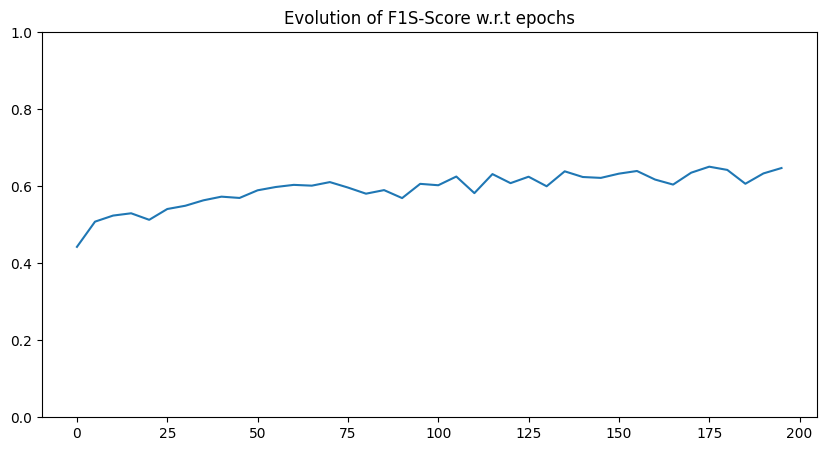

In [8]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))

### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores) :
    plt.figure(figsize=[10,5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores)

### <font color='red'> Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells. You can either use the architectures you learned from the lecture, or try to come up with an idea of your own.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [9]:
# Your solution here ###########################################################

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
class StudentModel(nn.Module):
  def __init__(
        self, 
        input_size, 
        hidden_size, 
        output_size, 
        use_skip_connection=True,
        heads=1,
        output_heads=6,
    ):
      super().__init__()
      
      ####### YOUR ANSWER #######
      self.gc1 = graphnn.GATConv(input_size, hidden_size, heads=heads, act=None)
      print(input_size * heads)
      self.gc2 = graphnn.GATConv(hidden_size * heads, hidden_size, heads=heads, act=None)
      self.gc3 = graphnn.GATConv(hidden_size * heads, output_size, heads=output_heads, act=None, concat=False)   

      if use_skip_connection:
         self.opt_skip = lambda x, edge_index, layer: x + layer(x, edge_index)
      else:
         self.opt_skip = lambda x, edge_index, layer: layer(x, edge_index)

      
  def forward(self, x, edge_index):

      ####### YOUR ANSWER #######
      x = self.gc1(x, edge_index)
      x = F.elu(x)
      x = self.opt_skip(x, edge_index, self.gc2)
      x = F.elu(x)
      x = self.gc3(x, edge_index)

      return x

In [10]:
## Student model
student_model = StudentModel(
    input_size=n_features, 
    hidden_size=256, 
    output_size=n_classes,
    heads=4,
    ).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

200
Epoch 00001 | Loss: 0.6957
F1-Score: 0.4348
Epoch 00002 | Loss: 0.5618
Epoch 00003 | Loss: 0.5440
Epoch 00004 | Loss: 0.5228
Epoch 00005 | Loss: 0.5157
Epoch 00006 | Loss: 0.5032
F1-Score: 0.5183
Epoch 00007 | Loss: 0.4960
Epoch 00008 | Loss: 0.4899
Epoch 00009 | Loss: 0.4807
Epoch 00010 | Loss: 0.4720
Epoch 00011 | Loss: 0.4640
F1-Score: 0.5469
Epoch 00012 | Loss: 0.4563
Epoch 00013 | Loss: 0.4617
Epoch 00014 | Loss: 0.4545
Epoch 00015 | Loss: 0.4434
Epoch 00016 | Loss: 0.4362
F1-Score: 0.6253
Epoch 00017 | Loss: 0.4303
Epoch 00018 | Loss: 0.4233
Epoch 00019 | Loss: 0.4219
Epoch 00020 | Loss: 0.4200
Epoch 00021 | Loss: 0.4171
F1-Score: 0.6551
Epoch 00022 | Loss: 0.4061
Epoch 00023 | Loss: 0.3968
Epoch 00024 | Loss: 0.3889
Epoch 00025 | Loss: 0.3830
Epoch 00026 | Loss: 0.3800
F1-Score: 0.6888
Epoch 00027 | Loss: 0.3734
Epoch 00028 | Loss: 0.3729
Epoch 00029 | Loss: 0.3702
Epoch 00030 | Loss: 0.3616
Epoch 00031 | Loss: 0.3508
F1-Score: 0.7096
Epoch 00032 | Loss: 0.3429
Epoch 00033 |

Student Model : F1-Score on the test set: 0.9219


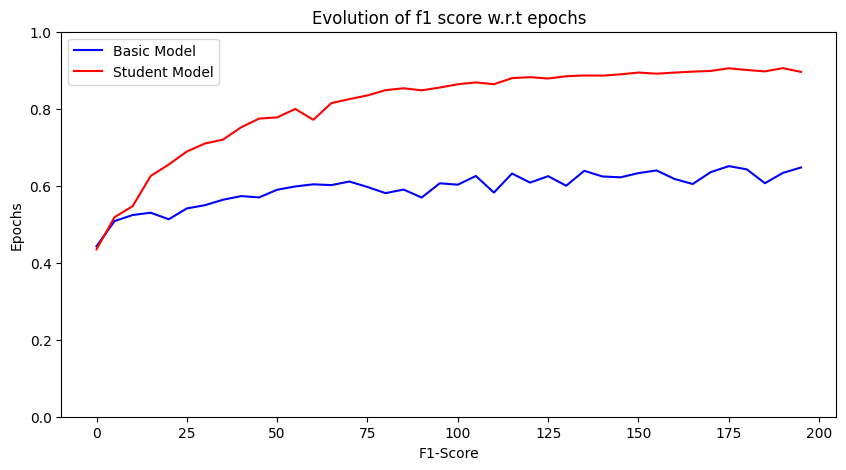

In [11]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

def plot_f1_score(epoch_list, basic_model_scores, student_model_scores) :
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, basic_model_scores, 'b', label = "Basic Model")
    plt.plot(epoch_list, student_model_scores, 'r', label = "Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
print(f"Number of parameters in the basic model: {count_parameters(basic_model)}")
print(f"Number of parameters in the student model: {count_parameters(student_model)}")

Number of parameters in the basic model: 109945
Number of parameters in the student model: 1850917


## <font color='red'> **PART 2 : QUESTIONS** (12pts)


<font color='red'> 1. Explains your achitecture and justifies your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).

> **Your answer here:** We followed the architecture from the original GAT paper. As you can see above, we use a 3 layer graph attention network with 4, 4 and 6 heads respectively. As suggested by the original work, we also use skip-connection. The hidden dimension is 256 and we average the output of the last layer heads to obtain the output logits. 

> The most notable difference between the GAT and GCN layer is that the GAT is able to give a different weight to each neighbor due to the attention mechanism. For a given center node $i$, the model uses the score computed between features of $i$ and its neighbors. That way, we can compute a weighted  average (weights = attention scores) between neighbors instead of a plain average. On the other hand, the GCN treats all neighbors similarly. As a consequence, it is generally less expressive than the GAT. 

<font color='red'>  2. Analyses your results (what is the F1-Score ? are your results convincing ?)

> **Your answer here:** The GAT obtains a test F1-score of 0.9284, while the GCN only attains 0.6172. We can explain this result from two factors. First, as observed in the original GAT paper, GCNs generally attains lower performance on the PPI dataset. On the other hand, we see that our GAT model has much more parameters (18x more) than the baseline in this notebook. Nonetheless, note that the GAT-based model is not overfitting the dataset as the test performance remains high. Hence it is able to use its capacity adequately.

> In order to understand better which factor explains the performance boost the most, one should conduct an ablation study. We would compare different pairs of GCN and GAT based models with close number of parameters and observe how the performance is affected. As it is not the goal of this homework, we prefered to spend more time on the project and other courses.


<font color='red'> 3. Provide a diagram of your architecture, which includes a good and clear legend as well as shapes information. The diagram must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted).

> **Your answer here:**
![Student model architecture](https://github.com/deschena/networks_ml_epfl/blob/main/assignment4/model_architecture.jpg?raw=1)


<font color='red'> 4. What is the name of the problem that arises when using deep GNNs? Define and explain this problem.

> **Your answer here:** The over-smoothing or over-mixing problem is a key challenge when using deep GNNs.

> Over-smoothing occurs when information from neighbouring nodes in the graph is excessively aggregated through the process of message-passing across multiple layers. As the network depth increases, the repeated application of Laplacian-type graph convolutions causes the node representations to become increasingly similar, making them indistinguishable from each other.

<font color='red'> 5. Are there solutions to overcome it ? 

> **Your answer here:** Several techniques have been proposed to mitigate the over-smoothing problem in deep GNNs:

> 1.   **Skip-connections**: as observed in other domains and models (eg computer vision or transformers), skip-connections allow better gradient propagation through layers and in the case of deep GNN, preserves discriminative features and mitigates the over-smoothing problem.
> 2.   Attention mechanisms: Attention-based GNN layers, such as GATs, can focus on more informative neighbors during the aggregation process, hence, there is less risk of (plainly) averaging the features of all nodes in a neighborhood.
> 3.   Coarsening and pooling operations: By coarsening the graph structure and reducing the number of nodes, it was observed that the problem is aleviated.